In [1]:
%matplotlib inline
import random
import torch
from torch import nn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import os

from models import Generator2, Discriminator2, Generator, Discriminator
from datasets import GrayscaleImageFolder

# Set random seed for reproducibility
manualSeed = 42
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)

# Root directory for dataset
dataroot = "D:/Data/Lung/images/RawExports/"


batch_size = 64
resized_size = 256
real_image_channels = 1
noise_vector_size = 100
generator_features = 64
discriminator_features = 64
filename_filter='merőleges_LUA'
num_epochs = 20
lr = 0.0002
beta1 = 0.7

Random Seed:  42


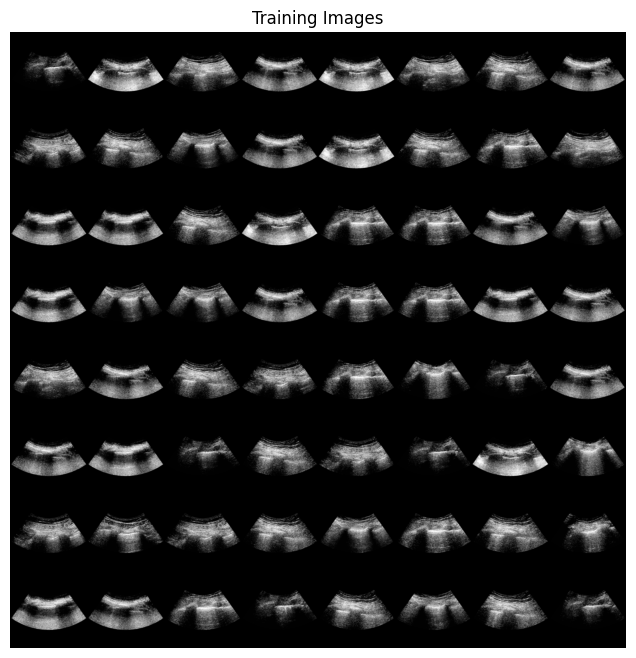

In [2]:
dataset_transform = transforms.Compose([
    transforms.Resize(resized_size),
    transforms.CenterCrop(resized_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
]) 


dataset = GrayscaleImageFolder(root=dataroot,
                               transform=dataset_transform,
                               filename_filter=filename_filter)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

# Decide which device we want to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [3]:
generator = Generator(in_channels=noise_vector_size,
                       feature_channels=generator_features,
                       out_channels=real_image_channels).to(device)

discriminator = Discriminator(in_channels=real_image_channels,
                               feature_channels=discriminator_features,
                               input_size=resized_size).to(device)

criterion = nn.BCELoss()
fixed_noise = torch.randn(64, noise_vector_size, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

In [4]:
# Training Loop
continue_previous_training = False

experiment_name = '256_LUA_only'
if not os.path.exists(f'runs/{experiment_name}'):
    os.makedirs(f'runs/{experiment_name}')

# Lists to keep track of progress
if not continue_previous_training:
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, noise_vector_size, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        
        torch.jit.save(torch.jit.script(generator), f'runs/{experiment_name}/generator_last.pt')
        torch.jit.save(torch.jit.script(discriminator), f'runs/{experiment_name}/discriminator_last.pt')
        if errG == np.min(G_losses):
            torch.jit.save(torch.jit.script(generator), f'runs/{experiment_name}/gen_best.pt')
            torch.jit.save(torch.jit.script(discriminator), f'runs/{experiment_name}/discriminator_best.pt')
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/20][0/113]	Loss_D: 1.3807	Loss_G: 0.6818	D(x): 0.5031	D(G(z)): 0.5003 / 0.5057
[0/20][50/113]	Loss_D: 1.5303	Loss_G: 0.2950	D(x): 1.0000	D(G(z)): 0.7805 / 0.7455


RuntimeError: File runs/256_LUA_only/generator_last.pt cannot be opened.

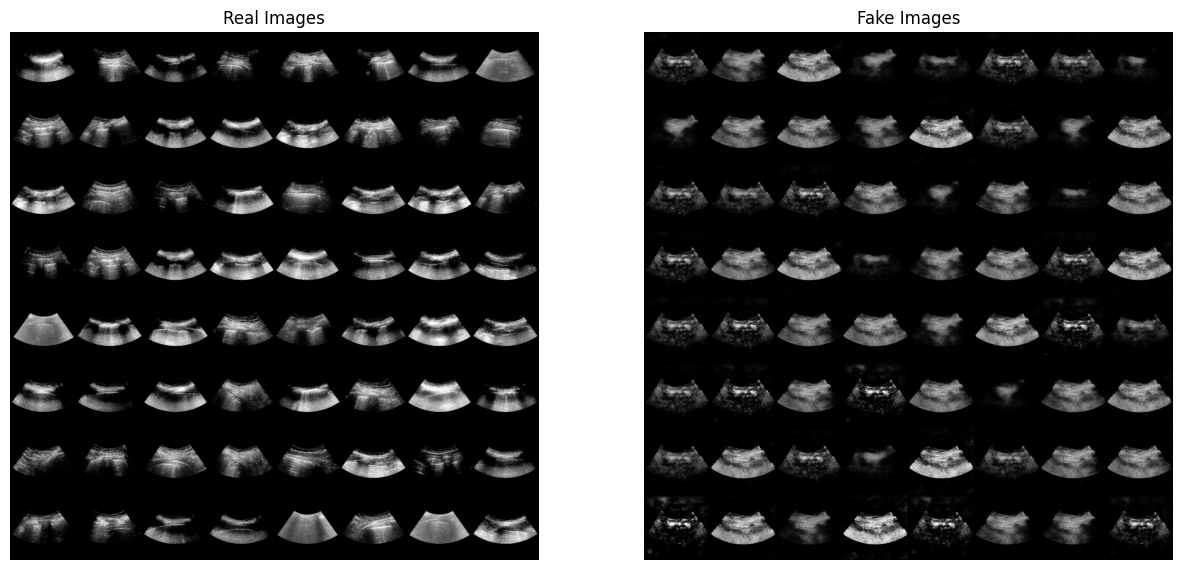

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()